# Food Policy in Nigeria

## Project Setup

In [1]:
!pip install -r requirements.txt
!pip install python-dateutil
!pip install fooddatacentral

  Using cached CFEDemands-0.5.4-py2.py3-none-any.whl (47 kB)
  Using cached ConsumerDemands-0.4.1.dev0-py2.py3-none-any.whl (12 kB)
  Using cached eep153_tools-0.11-py2.py3-none-any.whl (4.4 kB)
  Using cached python_gnupg-0.5.0-py2.py3-none-any.whl (18 kB)
  Using cached dvc-2.55.0-py3-none-any.whl (419 kB)
  Using cached xarray-2023.4.2-py3-none-any.whl (979 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached ray-2.4.0-cp39-cp39-manylinux2014_x86_64.whl (58.6 MB)
  Using cached pandas-2.0.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Using cached iterative_telemetry-0.0.8-py3-none-any.whl (10 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl (154 kB)
  Using cached shortuuid-1.0.11-py3-none-any.whl (10 kB)
  Using cached voluptuous-0.13.1-py3-none-any.whl (29 kB)
  Using cached dpath-2.1.5-py3-none-any.whl (17 k

In [2]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

apikey = "lxD6lWLfAtFMmMogo98BZyZakAnjLIADqzEbiTjs" 

## [A] Choice of dataset  
We chose the dataset of Nigeria and explored on its consumption patterns, household characteristics, and expenditures on food.

In [3]:
#load datset
consumption_ownprod = pd.read_excel('Nigeria LSMS Consumption from Own Production.xlsx')
consumption = pd.read_excel('Nigeria LSMS Consumption.xlsx')
expenditures = pd.read_excel('Nigeria LSMS.xlsx',sheet_name='Expenditures')
hh_characteristics = pd.read_excel('Nigeria LSMS.xlsx',sheet_name='HH Characteristics')
fct = pd.read_excel('WAFCT_2019.xlsx', sheet_name='05 NV_sum_57 (per 100g EP)')

## Estimation Example

### Data

In [4]:
#household characteristics
hh_characteristics.columns.name = 'k'
hh_characteristics.set_index(['i','t','m'],inplace=True)

#expenditure
expenditures.columns.name = 'j'

expenditures = expenditures.groupby('j',axis=1).sum()
expenditures = expenditures.replace(0,np.nan)
expenditures1 = np.log(expenditures.set_index(['i','t','m']))

#consumption
if 'm' not in consumption.columns:
    consumption['m'] = 1

consumption = consumption.set_index(['i','t','m','u'])
consumption.columns.name = 'k'

consumption = consumption.apply(lambda x: pd.to_numeric(x,errors='coerce'))
consumption = consumption.replace(0,np.nan)

In [5]:
#fct
fct.index.name = 'i'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

#RDI
rdi = get_clean_sheet('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ',
                    sheet='RDI')
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.


In [6]:
from cfe.estimation import drop_columns_wo_covariance

expenditures1 = drop_columns_wo_covariance(expenditures1,min_obs=30)

Missing dependencies for OracleDemands.


In [7]:
use = expenditures1.index.intersection(hh_characteristics.index)
expenditures1 = expenditures1.loc[use,:]
hh_characteristics = hh_characteristics.loc[use,:]

In [8]:
expenditures1 #drop half

,,j,"(Cocoyam, Spinach, etc)",Agricultural eggs,Bananas,Beef,Biscuits,Bread,Brown beans,Cassava flour,Chicken,Chocolate drinks,...,"Soft drinks (Coca cola, spirit etc)",Sugar,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Yam-roots
i,t,m,,,,,,,,,,,,,,,,,,,,,
10001,2010,Nigeria,NaN,5.634790,5.298317,6.214608,NaN,6.620073,NaN,NaN,7.244228,6.309918,...,5.010635,5.298317,5.010635,NaN,5.010635,5.010635,NaN,NaN,6.396930,7.313220
10002,2010,Nigeria,NaN,5.634790,5.192957,7.090077,NaN,6.109248,NaN,NaN,7.649693,5.857933,...,6.802395,5.298317,5.298317,4.941642,5.480639,4.787492,NaN,NaN,5.991465,7.090077
10003,2010,Nigeria,NaN,5.192957,4.605170,6.214608,NaN,5.298317,NaN,NaN,NaN,NaN,...,NaN,3.401197,5.298317,4.094345,4.499810,4.605170,NaN,NaN,4.605170,5.991465
10004,2010,Nigeria,NaN,5.192957,4.605170,6.214608,NaN,4.787492,NaN,NaN,NaN,NaN,...,NaN,3.688879,NaN,3.401197,4.094345,4.605170,NaN,NaN,4.605170,5.991465
10006,2010,Nigeria,NaN,NaN,5.703782,5.703782,NaN,5.010635,5.192957,NaN,NaN,NaN,...,NaN,2.302585,NaN,6.476972,NaN,5.991465,NaN,NaN,NaN,5.991465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379146,2018,Nigeria,NaN,7.003065,NaN,NaN,NaN,6.684612,7.408531,5.703782,NaN,6.684612,...,7.600902,NaN,NaN,NaN,NaN,NaN,6.214608,NaN,NaN,7.495542
379148,2018,Nigeria,4.605170,NaN,NaN,6.551080,NaN,5.521461,6.309918,NaN,NaN,6.109248,...,NaN,NaN,NaN,NaN,4.094345,5.298317,5.010635,NaN,NaN,7.377759
379151,2018,Nigeria,NaN,6.802395,6.214608,NaN,NaN,6.109248,NaN,NaN,8.006368,6.109248,...,NaN,4.605170,NaN,NaN,5.010635,6.396930,6.396930,6.620073,7.377759,8.160518


In [9]:
use = expenditures1.index.intersection(hh_characteristics.index)
expenditures1 = expenditures1.loc[use,:]
hh_characteristics = hh_characteristics.loc[use,:]

## [A] Estimate Demand System

In [10]:
expenditures2 = expenditures1.stack()
hh_characteristics1 = hh_characteristics.stack()

assert expenditures2.index.names == ['i','t','m','j']
assert hh_characteristics1.index.names == ['i','t','m','k']

#### Basic Estimation

In [11]:
from cfe import Regression

result = Regression(y=expenditures2,d=hh_characteristics1)

In [12]:
result.predicted_expenditures()

i       t     m        j                      
10001   2010  Nigeria  (Cocoyam, Spinach, etc)     156.909249
                       Agricultural eggs           397.586147
                       Bananas                     265.637209
                       Beef                       1000.482019
                       Bread                       394.467437
                                                     ...     
379155  2018  Nigeria  Tomato puree(canned)        269.917715
                       Tomatoes                    308.927296
                       Wheat flour                 855.235718
                       White beans                 881.728278
                       Yam-roots                  1251.744786
Length: 708167, dtype: float64

#### Income Elasticity

In [13]:
result.get_beta().sort_values()

j
Fish-Frozen                             0.246842
Other vegetables (fresh or canned)      0.253198
Garden eggs/egg plant                   0.257859
Okra-fresh                              0.295308
Pineapples                              0.295379
(Cocoyam, Spinach, etc)                 0.305324
Chicken                                 0.318017
Cassava flour                           0.321077
Goat                                    0.324849
Gari -Yellow                            0.326250
Milk tinned (unsweetened)               0.335286
Plantains                               0.336689
Okra-dried                              0.341528
Tomatoes                                0.341543
Beef                                    0.341884
Palm oil                                0.343210
Soft drinks (Coca cola, spirit etc)     0.343263
Yam-roots                               0.347992
Tomato puree(canned)                    0.352777
Orange/tangerine                        0.361425
Brown beans       

#### Demand and Household Composition

In [14]:
result.gamma

k,M 00-03,M 04-08,M 09-13,M 14-18,M 19-30,M 31-50,M 51+,F 00-03,F 04-08,F 09-13,F 14-18,F 19-30,F 31-50,F 51+,Constant
j,,,,,,,,,,,,,,,
"(Cocoyam, Spinach, etc)",-0.015192,0.012283,0.030412,-0.033765,0.048779,0.057815,0.101008,0.031863,0.028920,0.033931,0.048556,0.050374,0.070528,0.031611,-0.197808
Agricultural eggs,0.005273,0.047350,0.050232,0.015530,0.089903,0.219877,0.182996,0.053201,0.053745,0.019356,0.028243,0.094256,0.103635,-0.060144,-0.474118
Bananas,0.037509,0.019628,0.046346,0.056714,0.095653,0.124172,0.082554,0.023702,0.009165,0.050533,0.077732,0.056040,0.068480,-0.002241,-0.357297
Beef,0.035403,0.045631,0.032596,0.059631,0.084576,0.156356,0.147275,0.008473,0.033471,0.044356,0.055734,0.099305,0.059286,-0.004953,-0.434315
Bread,0.019121,0.050941,0.031611,0.056330,0.102693,0.172484,0.140703,0.016710,0.046773,0.063223,0.072251,0.102843,0.096053,0.017779,-0.442452
Brown beans,0.041103,0.073306,0.049682,0.065975,0.070143,0.130769,0.110357,0.041433,0.026002,0.061614,0.090390,0.073097,0.110112,0.060538,-0.388814
Cassava flour,0.003404,0.100233,0.033744,0.085940,0.066803,0.088818,0.074925,-0.067421,0.068931,-0.010453,0.085130,0.052734,0.093547,0.013511,-0.296914
Chicken,-0.007596,0.033497,-0.014040,0.032923,0.082972,0.133768,0.161904,-0.062432,0.011918,0.011559,0.042921,0.103479,0.126613,-0.005463,-0.526734
Chocolate drinks,0.067683,0.016802,0.045409,0.003374,0.071992,0.145705,0.183903,0.076143,0.037072,0.028193,0.077367,0.131429,0.080670,-0.002316,-0.368023


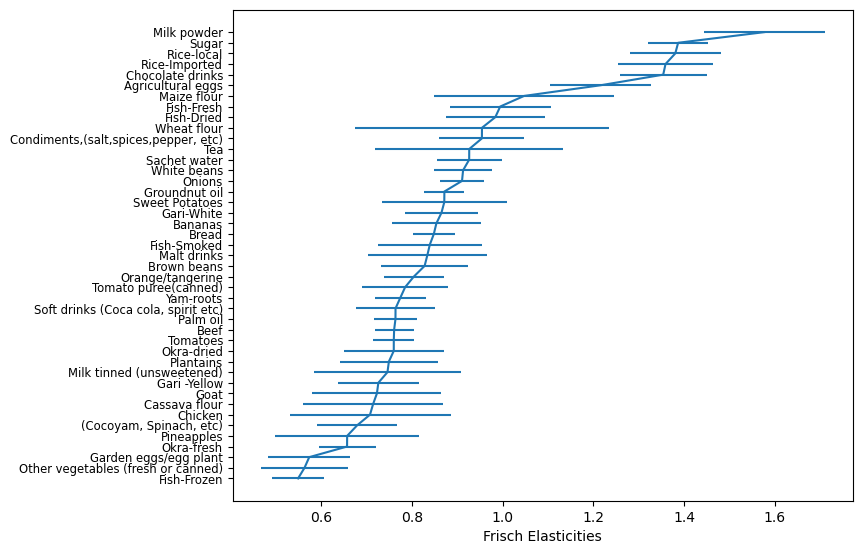

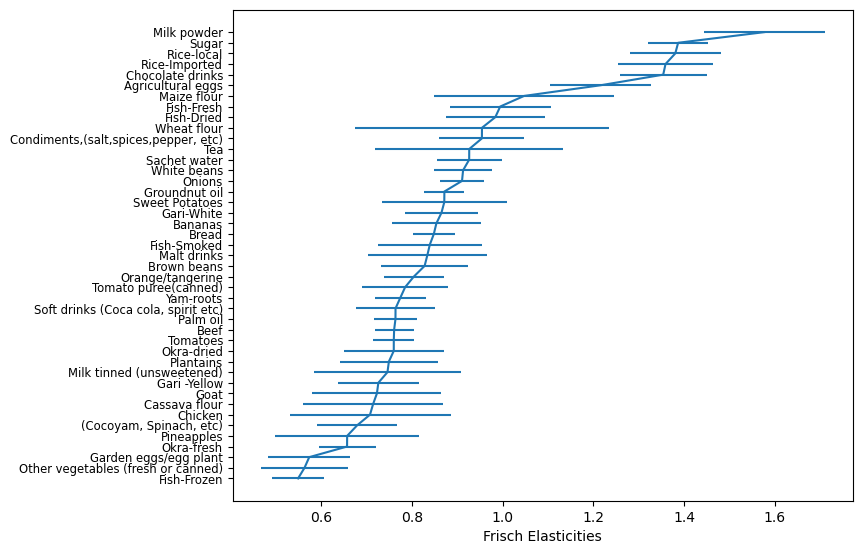

In [15]:
result.graph_beta()

## [A] Nutrition System  
Here we collected the nutritional contents of 42 types of foods in regression analysis.

In [16]:
food_codes = pd.read_excel('Food Codes for Nigeria.xlsx')

In [17]:
food_codes

,Food description,From Country,FDC Comments,COICOP,COICOP Comments,USDA FDC ID,WAFCT ID,WAFCT Comments
0,Guinea corn/sorghum,NGA,"""Sorghum grain""",01.1.1.1.3,NaN,169716,01_039,NaN
1,Millet,NGA,"""Cooked millet""",01.1.1.1.5,NaN,168871,01_017,NaN
2,Maize,NGA,WHOLE KERNEL CORN MAIZE,01.1.1.1.6,NaN,1441697,01_004,NaN
3,Rice-local,NGA,"Rice, white, long-grain, regular, unenriched, ...",01.1.1.1.2,NaN,169757,01_065,NaN
4,Rice-Imported,NGA,"Rice, white, long-grain, regular, unenriched, ...",01.1.1.1.2,NaN,169757,01_037,NaN
...,...,...,...,...,...,...,...,...
91,Beer (local and imported),NGA,Beer,02.1.3.0,NaN,1104393,12_001,NaN
92,Palm wine,NGA,"Alcoholic beverage, wine, table, all",02.1.2.2,Wine from other sources (ND),173185,12_006,NaN
93,Pito,NGA,Beer,02.1.3.0,Beer,1104393,12_003,NaN
94,Gin,NGA,Gin,02.1.9.0,Other alcoholic beverages,1104487,NaN,NaN


In [18]:
fc = result.get_beta().to_frame()
table = food_codes.loc[:, ['Food description', 'USDA FDC ID']]
fc_table = fc.merge(table, left_on = 'j', right_on = 'Food description', how = 'inner')
fc_table.head()

,beta,Food description,USDA FDC ID
0,0.679675,"(Cocoyam, Spinach, etc)",1320589
1,1.215686,Agricultural eggs,747997
2,0.854099,Bananas,1102653
3,0.761059,Beef,1098212
4,0.848466,Bread,325871


In [20]:
import warnings
import fooddatacentral as fdc

D = {}
count = 0
for food in fc.index:
    try:
        FDC = fc_table.loc[fc_table['Food description']==food,'USDA FDC ID'].values[0]
        count+=1
        D[food] = fdc.nutrients(apikey,FDC).Quantity
        print(food)
    except AttributeError:
        warnings.warn(f"Couldn't find FDC Code {FDC} for food {food}." % (food,FDC))

D = pd.DataFrame(D,dtype=float)


(Cocoyam, Spinach, etc)
Agricultural eggs
Bananas
Beef
Bread
Brown beans
Cassava flour
Chicken
Chocolate drinks
Condiments,(salt,spices,pepper, etc)
Fish-Dried
Fish-Fresh
Fish-Frozen
Fish-Smoked
Garden eggs/egg plant
Gari -Yellow
Gari-White
Goat
Groundnut oil
Maize flour
Malt drinks
Milk powder
Milk tinned (unsweetened)
Okra-dried
Okra-fresh
Onions
Orange/tangerine
Other vegetables (fresh or canned)
Palm oil
Pineapples
Plantains
Rice-Imported
Rice-local
Sachet water
Soft drinks (Coca cola, spirit etc)
Sugar
Sweet Potatoes
Tea
Tomato puree(canned)
Tomatoes
Wheat flour
White beans
Yam-roots


In [21]:
nutrition_chart = D.fillna(0)
nutrition_chart

,"(Cocoyam, Spinach, etc)",Agricultural eggs,Bananas,Beef,Bread,Brown beans,Cassava flour,Chicken,Chocolate drinks,"Condiments,(salt,spices,pepper, etc)",...,Sachet water,"Soft drinks (Coca cola, spirit etc)",Sugar,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Wheat flour,White beans,Yam-roots
Alanine,0.0,0.714,0.00,0.00,0.00,0.00,0.0,0.991,0.00,0.0,...,0.00,0.00,0.00,0.077,0.0,0.052,0.00,0.0,0.00,0.063
"Alcohol, ethyl",0.0,0.000,0.00,0.00,0.00,0.00,0.0,0.000,0.00,0.0,...,0.00,0.00,0.00,0.000,0.0,0.000,0.00,0.0,0.00,0.000
Amino acids,0.0,0.000,0.00,0.00,0.00,0.00,0.0,0.000,0.00,0.0,...,0.00,0.00,0.00,0.000,0.0,0.000,0.00,0.0,0.00,0.000
Arginine,0.0,0.691,0.00,0.00,0.00,0.00,0.0,1.128,0.00,0.0,...,0.00,0.00,0.00,0.055,0.0,0.032,0.00,0.0,0.00,0.127
Ash,0.0,0.650,0.00,0.00,2.10,0.00,0.0,1.170,0.00,0.0,...,0.00,0.00,0.01,0.990,0.0,1.280,0.00,0.0,0.00,0.820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vitamin K (Menaquinone-4),0.0,0.000,0.00,0.00,0.00,0.00,0.0,0.000,0.00,0.0,...,0.00,0.00,0.00,0.000,0.0,0.000,0.00,0.0,0.00,0.000
Vitamin K (phylloquinone),0.0,0.000,0.50,1.70,0.00,0.00,0.0,0.800,0.20,0.0,...,0.00,0.00,0.00,1.800,0.0,3.400,7.90,0.0,0.00,2.300
Vitamins and Other Components,0.0,0.000,0.00,0.00,0.00,0.00,0.0,0.000,0.00,0.0,...,0.00,0.00,0.00,0.000,0.0,0.000,0.00,0.0,0.00,0.000
Water,0.0,86.300,74.91,62.58,35.70,0.00,0.0,73.240,78.43,0.0,...,99.90,89.36,0.02,77.280,0.0,87.880,94.52,0.0,0.00,69.600


## [A] Nutritional Challenge

In [22]:
#calculate household recommended intake
hh_characteristics = hh_characteristics[rdi.columns.tolist()]

hh_rdi = hh_characteristics@rdi.T
hh_rwi = hh_rdi*7

In [23]:
#Nigeria data is weekly, so convert to weekly household recommended intake
hh_rwi.head()

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Magnesium,Niacin,Phosphorus,Potassium,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Vitamin E,Vitamin K,Zinc
i,t,m,,,,,,,,,,,,,,,,,,,,
10001,2010,Nigeria,93800.0,2233.0,1313.2,17850.0,46900.0,6370.0,595.0,15890.0,672.0,32620.0,218400.0,53.9,51.8,35700.0,107.1,58.1,3570.0,672.0,4620.0,420.0
10002,2010,Nigeria,100800.0,2352.0,1411.2,18900.0,53200.0,6370.0,623.0,16870.0,714.0,42000.0,228900.0,56.7,54.6,37800.0,113.4,61.6,3675.0,707.0,4515.0,455.0
10003,2010,Nigeria,75600.0,1687.0,1058.4,14000.0,48300.0,5460.0,441.0,12320.0,546.0,39550.0,188300.0,42.7,41.3,28700.0,84.0,48.3,2485.0,518.0,3220.0,357.0
10004,2010,Nigeria,37800.0,952.0,529.2,7700.0,24500.0,2730.0,168.0,6860.0,294.0,18550.0,97300.0,23.1,22.4,15400.0,46.2,29.4,1470.0,287.0,1890.0,189.0
10006,2010,Nigeria,46200.0,1106.0,646.8,8400.0,21000.0,2730.0,238.0,7910.0,322.0,14700.0,98700.0,25.9,24.5,17500.0,50.4,27.3,1785.0,315.0,2310.0,210.0


In [24]:
consumption_purchase = consumption.fillna(0).loc[:,consumption.count()>0]
consumption1 = consumption_ownprod.fillna(0).replace('0. NONE', 0).loc[:,consumption_ownprod.count()>0].set_index(['i', 't','m', 'u'])

In [25]:
units_purchase = consumption_purchase.index.levels[3].unique()
#Convert units to FDC units
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[0]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[0]]*10
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[1]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[1]]/100
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[2]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[2]]/100
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[3]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[3]]*10
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[4]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[4]]/100
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[5]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[5]]*400
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[6]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[6]]*250
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[7]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[7]]*100
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[8]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[8]]*500
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[9]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[9]]*300
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[10]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[10]]*150
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[11]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[11]]*50
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[12]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[12]]*150
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[13]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[13]]*80
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[14]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[14]]/100
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[15]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[15]]*10
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[16]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[16]]*10
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[17]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[17]]*0.01
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[18]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[18]]*500
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[19]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[19]]*200
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[20]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[20]]*80
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[21]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[21]]*50
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[22]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[22]]*30
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[23]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[23]]*600
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[24]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[24]]*0.1
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[25]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[25]]/100
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[26]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[26]]*10
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[27]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[27]]*10

In [26]:
food_list = fc_table['Food description'].to_list()

In [27]:
#Consumption of each household all in FDC units
#Treat each household in different year as an individual observation
consumption_purchase = consumption_purchase.groupby(['i','t']).sum()
consumption_purchase.columns.name = None
consumption_purchase = consumption_purchase.loc[:,food_list]
consumption_purchase.head()

(Cocoyam, Spinach, etc)  Agricultural eggs  Bananas  Beef   
i       t                                                                   
10001.0 2010.0                      0.0                8.9     13.0  10.0  \
        2012.0                      0.0                0.0      0.0   0.0   
        2015.0                      0.0                0.0      0.0  20.0   
        2018.0                      0.0                0.0      0.0  10.0   
10002.0 2010.0                      0.0                8.9     13.0  20.0   

                Bread  Brown beans  Cassava flour  Chicken  Chocolate drinks   
i       t                                                                      
10001.0 2010.0   25.0          0.0            0.0     20.0              5.00  \
        2012.0    8.0          0.0            0.0     30.0              2.25   
        2015.0    0.0          0.0            0.0      0.0              0.00   
        2018.0    0.0          0.0            0.0      0.0              0.00   
10002.0 2010.0   15.0          0.0            0.0     30.0              5.00   

                Condiments,(salt,spices,pepper, etc)  ...  Sachet water   
i       t                                             ...                 
10001.0 2010.0                                   5.0  ...          30.0  \
        2012.0                                   0.0  ...           0.0   
        2015.0                                   0.0  ...           0.0   
        2018.0                                   0.0  ...           0.0   
10002.0 2010.0                                   5.0  ...          42.0   

                Soft drinks (Coca cola, spirit etc)  Sugar  Sweet Potatoes   
i       t                                                                    
10001.0 2010.0                                 10.5    5.0            15.0  \
        2012.0                                  0.0    0.0             0.0   
        2015.0                                  1.4    0.0             0.0   
        2018.0                                  0.0    0.0             0.0   
10002.0 2010.0                                 84.0    5.0            18.0   

                Tea  Tomato puree(canned)  Tomatoes  Wheat flour  White beans   
i       t                                                                       
10001.0 2010.0  0.0                   4.2      10.0          0.0         30.0  \
        2012.0  0.0                   2.1       2.4          0.0          0.0   
        2015.0  0.0                   0.0       0.0          0.0          0.0   
        2018.0  0.0                   0.0       0.0          0.0          0.0   
10002.0 2010.0  1.2                   5.6      10.0          0.0         20.0   

                 Yam-roots  
i       t                   
10001.0 2010.0  160.000000  
        2012.0   98.999996  
        2015.0    0.000000  
        2018.0    0.000000  
10002.0 2010.0  138.000000  

[5 rows x 43 columns]

In [28]:
#nutritional intake of each household considering only purchase
nutri = consumption_purchase@nutrition_chart.T
nutri

Alanine  Alcohol, ethyl  Amino acids  Arginine         Ash   
i        t                                                                     
10001.0  2010.0  115.8758          50.820          0.0  162.2677  441.317000  \
         2012.0   36.3828           0.000          0.0   54.3930  144.929997   
         2015.0    0.0000           5.082          0.0    0.0000    0.000000   
         2018.0    0.0000           0.000          0.0    0.0000    0.000000   
10002.0  2010.0   58.5438          25.410          0.0   74.9331  238.973000   
...                   ...             ...          ...       ...         ...   
379146.0 2018.0    0.0000           0.000          0.0   15.1200   11.100000   
379148.0 2018.0    0.0000           0.000          0.0    0.0000    0.000000   
379151.0 2018.0    0.0000           0.000          0.0    0.0000    0.000000   
379154.0 2018.0   49.5500           0.000          0.0   56.4000   58.500000   
379155.0 2018.0    0.0000           0.000          0.0    0.0000    0.000000   

                 Aspartic acid  Betaine  Boron, B  Caffeine   Calcium, Ca   
i        t                                                                  
10001.0  2010.0     202.795200   154.84   36900.0    109.50  29222.600000  \
         2012.0      64.866599   231.42       0.0      6.75   8304.449932   
         2015.0       0.000000     0.00       0.0     12.60    346.680000   
         2018.0       0.000000     0.00       0.0      0.00    170.000000   
10002.0  2010.0     109.751600   232.12   24600.0    771.00  20046.700000   
...                        ...      ...       ...       ...           ...   
379146.0 2018.0       0.000000     0.00       0.0      0.00    130.000000   
379148.0 2018.0       0.000000     0.00       0.0      0.00     85.000000   
379151.0 2018.0       0.000000     0.00       0.0      0.00      0.000000   
379154.0 2018.0      80.800000   385.00       0.0      0.00    470.000000   
379155.0 2018.0       0.000000     0.00       0.0      0.00    170.000000   

                 ...  Vitamin D (D2 + D3), International Units   
i        t       ...                                             
10001.0  2010.0  ...                                       0.0  \
         2012.0  ...                                       0.0   
         2015.0  ...                                       0.0   
         2018.0  ...                                       0.0   
10002.0  2010.0  ...                                      80.0   
...              ...                                       ...   
379146.0 2018.0  ...                                       0.0   
379148.0 2018.0  ...                                       0.0   
379151.0 2018.0  ...                                       0.0   
379154.0 2018.0  ...                                       0.0   
379155.0 2018.0  ...                                       0.0   

                 Vitamin D3 (cholecalciferol)  Vitamin E (alpha-tocopherol)   
i        t                                                                    
10001.0  2010.0                           0.0                    711.306000  \
         2012.0                           0.0                    173.284499   
         2015.0                           0.0                    319.700000   
         2018.0                           0.0                      1.700000   
10002.0  2010.0                           2.0                    679.146000   
...                                       ...                           ...   
379146.0 2018.0                           0.0                    470.700000   
379148.0 2018.0                           0.0                      0.850000   
379151.0 2018.0                           0.0                   1108.300000   
379154.0 2018.0                           0.0                     15.200000   
379155.0 2018.0                           0.0                      1.700000   

                 Vitamin E, added  Vitamin K (Dihydrophylloquinone)   
i        t       

In [29]:
use = nutri.columns.intersection(hh_rwi.columns)
nutrient_ratio = (nutri[use]/hh_rwi[use]).dropna()

nutrient_ratio

Energy    Niacin   Protein  Riboflavin   Thiamin   
i        t      m                                                             
10001.0  2010.0 Nigeria  5.497453  1.032000  1.817597    0.695647  1.018127  \
         2012.0 Nigeria  1.038368  0.479420  0.540064    0.330690  0.437206   
         2015.0 Nigeria  0.789861  0.187935  0.250821    0.084599  0.024644   
         2018.0 Nigeria  0.037538  0.087857  0.116422    0.039221  0.011376   
10002.0  2010.0 Nigeria  2.434771  0.719661  1.054157    0.549002  0.662396   
...                           ...       ...       ...         ...       ...   
379146.0 2018.0 Nigeria  0.541463  0.086406  0.137517    0.140000  0.033435   
379148.0 2018.0 Nigeria  0.073512  0.192187  0.222449    0.082967  0.025595   
379151.0 2018.0 Nigeria  2.816460  0.000000  0.156085    0.000000  0.000000   
379154.0 2018.0 Nigeria  1.156071  1.532381  1.465546    0.807143  0.365217   
379155.0 2018.0 Nigeria  0.053463  0.133696  0.177959    0.059921  0.017551   

                         Vitamin B-12  Vitamin B-6  
i        t      m                                   
10001.0  2010.0 Nigeria      0.886387     2.418437  
         2012.0 Nigeria      0.592165     0.870145  
         2015.0 Nigeria      0.585214     0.157605  
         2018.0 Nigeria      0.276705     0.070996  
10002.0  2010.0 Nigeria      0.669189     1.553052  
...                               ...          ...  
379146.0 2018.0 Nigeria      0.168155     0.000000  
379148.0 2018.0 Nigeria      0.639881     0.180220  
379151.0 2018.0 Nigeria      0.000000     0.000000  
379154.0 2018.0 Nigeria      1.473214     1.375238  
379155.0 2018.0 Nigeria      0.426587     0.123308  

[17023 rows x 7 columns]

In [30]:
units = consumption_ownprod.loc[:, 'u'].unique()
#Convert units to FDC units
consumption1.iloc[consumption1.index.get_level_values('u') == units[0]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[0]]*10
consumption1.iloc[consumption1.index.get_level_values('u') == units[1]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[1]]*10
consumption1.iloc[consumption1.index.get_level_values('u') == units[2]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[2]]/100
consumption1.iloc[consumption1.index.get_level_values('u') == units[3]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[3]]*100
consumption1.iloc[consumption1.index.get_level_values('u') == units[4]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[4]]*100
consumption1.iloc[consumption1.index.get_level_values('u') == units[5]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[5]]*50
consumption1.iloc[consumption1.index.get_level_values('u') == units[6]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[6]]*200
consumption1.iloc[consumption1.index.get_level_values('u') == units[7]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[7]]*30
consumption1.iloc[consumption1.index.get_level_values('u') == units[8]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[8]]*250
consumption1.iloc[consumption1.index.get_level_values('u') == units[9]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[9]]*80
consumption1.iloc[consumption1.index.get_level_values('u') == units[10]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[10]]*80
consumption1.iloc[consumption1.index.get_level_values('u') == units[11]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[11]]/100
consumption1.iloc[consumption1.index.get_level_values('u') == units[12]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[12]]*150
consumption1.iloc[consumption1.index.get_level_values('u') == units[13]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[13]]*600
#Missing data: 15kg for Bundle of Millet, G/corn, Sugarcane, Vegetable etc: Small
consumption1.iloc[consumption1.index.get_level_values('u') == units[14]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[14]]*150
#Missing data: 15kg for Bundle of Millet, G/corn, Sugarcane, Vegetable etc: Medium
consumption1.iloc[consumption1.index.get_level_values('u') == units[15]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[15]]*250
consumption1.iloc[consumption1.index.get_level_values('u') == units[16]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[16]]*250
consumption1.iloc[consumption1.index.get_level_values('u') == units[17]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[17]]*300
consumption1.iloc[consumption1.index.get_level_values('u') == units[18]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[18]]*50
consumption1.iloc[consumption1.index.get_level_values('u') == units[19]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[19]]*1200
consumption1.iloc[consumption1.index.get_level_values('u') == units[20]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[20]]*500
consumption1.iloc[consumption1.index.get_level_values('u') == units[21]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[21]]*150
consumption1.iloc[consumption1.index.get_level_values('u') == units[22]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[22]]*400
consumption1.iloc[consumption1.index.get_level_values('u') == units[23]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[23]]*750
consumption1.iloc[consumption1.index.get_level_values('u') == units[24]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[24]]*500
consumption1.iloc[consumption1.index.get_level_values('u') == units[25]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[25]]*200
consumption1.iloc[consumption1.index.get_level_values('u') == units[26]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[26]]*400
consumption1.iloc[consumption1.index.get_level_values('u') == units[27]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[27]]/100
consumption1.iloc[consumption1.index.get_level_values('u') == units[28]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[28]]/100
consumption1.iloc[consumption1.index.get_level_values('u') == units[29]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[29]]*10
consumption1.iloc[consumption1.index.get_level_values('u') == units[30]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[30]]*10
consumption1.iloc[consumption1.index.get_level_values('u') == units[31]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[31]]*10
consumption1.iloc[consumption1.index.get_level_values('u') == units[32]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[32]]*250
consumption1.iloc[consumption1.index.get_level_values('u') == units[33]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[33]]*0.01
consumption1.iloc[consumption1.index.get_level_values('u') == units[34]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[34]]/100
consumption1.iloc[consumption1.index.get_level_values('u') == units[35]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[35]]/100

In [31]:
#Consumption from own production for each household all in FDC units
consumption1 = consumption1.groupby(['i','t']).sum()
consumption1 = consumption1.loc[1:,food_list]

In [32]:
nutri_prod = consumption1@nutrition_chart.T
nutri_prod

Alanine  Alcohol, ethyl  Amino acids  Arginine         Ash   
i        t                                                                    
10001.0  2012.0  36.3828           0.000          0.0    54.393  144.929997  \
         2015.0   0.0000           5.082          0.0     0.000    0.000000   
         2018.0   0.0000           0.000          0.0     0.000    0.000000   
10002.0  2012.0  32.2468           5.082          0.0    50.404  141.339998   
         2015.0  19.8200           5.082          0.0    22.560   23.400000   
...                  ...             ...          ...       ...         ...   
379146.0 2018.0   0.0000           0.000          0.0     0.000    0.000000   
379148.0 2018.0   0.0000           0.000          0.0     0.000    0.000000   
379151.0 2018.0   0.0000           0.000          0.0     0.000    0.000000   
379154.0 2018.0   0.0000           0.000          0.0     0.000    0.000000   
379155.0 2018.0   0.0000           0.000          0.0     0.000    0.000000   

                 Aspartic acid  Betaine  Boron, B  Caffeine  Calcium, Ca  ...   
i        t                                                                ...   
10001.0  2012.0      64.866599   231.42       0.0      6.75  8354.449932  ...  \
         2015.0       0.000000     0.00       0.0     12.60   346.680000  ...   
         2018.0       0.000000     0.00       0.0      0.00     0.000000  ...   
10002.0  2012.0      58.801600   192.92       0.0     13.05  8019.279969  ...   
         2015.0      32.320000   154.00       0.0     12.60   296.680000  ...   
...                        ...      ...       ...       ...          ...  ...   
379146.0 2018.0       0.000000     0.00       0.0      0.00     0.000000  ...   
379148.0 2018.0       0.000000     0.00       0.0      0.00     0.000000  ...   
379151.0 2018.0       0.000000     0.00       0.0      0.00     0.000000  ...   
379154.0 2018.0       0.000000     0.00       0.0      0.00     0.000000  ...   
379155.0 2018.0       0.000000     0.00       0.0      0.00     0.000000  ...   

                 Vitamin D (D2 + D3), International Units   
i        t                                                  
10001.0  2012.0                                       0.0  \
         2015.0                                       0.0   
         2018.0                                       0.0   
10002.0  2012.0                                       0.0   
         2015.0                                       0.0   
...                                                   ...   
379146.0 2018.0                                       0.0   
379148.0 2018.0                                       0.0   
379151.0 2018.0                                       0.0   
379154.0 2018.0                                       0.0   
379155.0 2018.0                                       0.0   

                 Vitamin D3 (cholecalciferol)  Vitamin E (alpha-tocopherol)   
i        t                                                                    
10001.0  2012.0                           0.0                     74.649999  \
         2015.0                           0.0                   7910.900000   
         2018.0                           0.0                      0.000000   
10002.0  2012.0                           0.0                     87.678999   
         2015.0                           0.0                   7914.600000   
...                                       ...                           ...   
379146.0 2018.0                           0.0                      0.000000   
379148.0 2018.0                           0.0                      0.000000   
379151.0 2018.0                           0.0                      0.000000   
379154.0 2018.0                           0.0                      0.000000   
379155.0 2018.0                           0.0                      0.000000   

                 Vitamin E, added  Vitamin K (Dihydrophylloquinone)   
i        t                                

In [33]:
nutri_total = pd.concat([nutri_prod,nutri]).groupby(['i', 't']).sum()

nutrient_ratio_total = (nutri_total[use]/hh_rwi[use]).dropna()

nutrient_ratio_total

Energy    Niacin   Protein  Riboflavin   Thiamin   
i        t      m                                                              
10001.0  2010.0 Nigeria   5.497453  1.032000  1.817597    0.695647  1.018127  \
         2012.0 Nigeria   1.938508  0.967975  1.084734    0.673945  0.879948   
         2015.0 Nigeria  18.659226  0.375870  0.501642    0.169198  0.049289   
         2018.0 Nigeria   0.037538  0.087857  0.116422    0.039221  0.011376   
10002.0  2010.0 Nigeria   2.434771  0.719661  1.054157    0.549002  0.662396   
...                            ...       ...       ...         ...       ...   
379146.0 2018.0 Nigeria   0.541463  0.086406  0.137517    0.140000  0.033435   
379148.0 2018.0 Nigeria   0.073512  0.192187  0.222449    0.082967  0.025595   
379151.0 2018.0 Nigeria   2.816460  0.000000  0.156085    0.000000  0.000000   
379154.0 2018.0 Nigeria   1.156071  1.532381  1.465546    0.807143  0.365217   
379155.0 2018.0 Nigeria   0.053463  0.133696  0.177959    0.059921  0.017551   

                         Vitamin B-12  Vitamin B-6  
i        t      m                                   
10001.0  2010.0 Nigeria      0.886387     2.418437  
         2012.0 Nigeria      1.184329     1.794340  
         2015.0 Nigeria      1.170427     0.315210  
         2018.0 Nigeria      0.276705     0.070996  
10002.0  2010.0 Nigeria      0.669189     1.553052  
...                               ...          ...  
379146.0 2018.0 Nigeria      0.168155     0.000000  
379148.0 2018.0 Nigeria      0.639881     0.180220  
379151.0 2018.0 Nigeria      0.000000     0.000000  
379154.0 2018.0 Nigeria      1.473214     1.375238  
379155.0 2018.0 Nigeria      0.426587     0.123308  

[17662 rows x 7 columns]

Text(0, 0.5, 'Ratio of recomended nutrients over actual consumption')

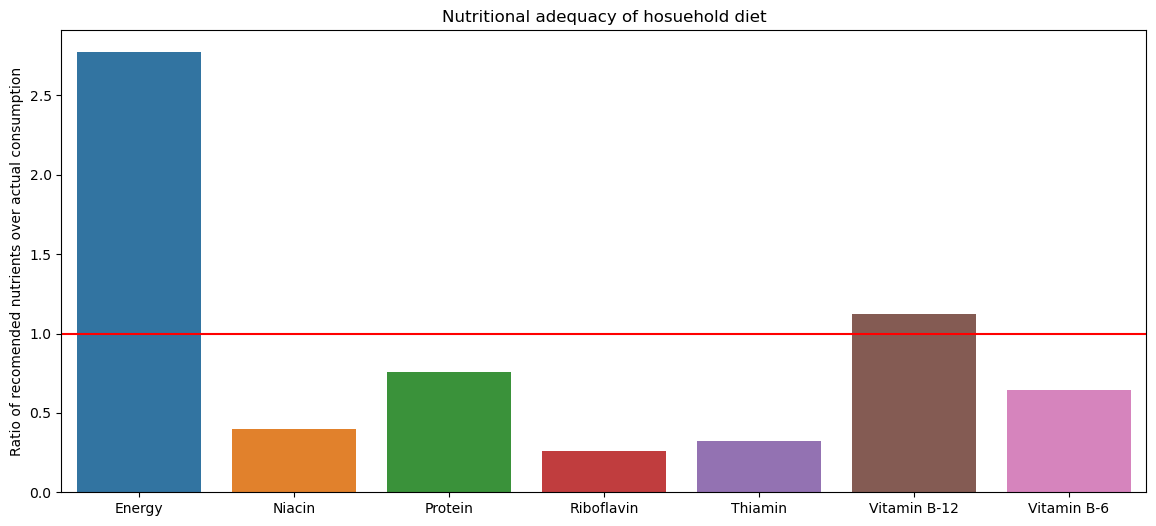

In [34]:
# Mean nutritional adequacy
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
sns.barplot(x=nutrient_ratio_total.mean().index, y=nutrient_ratio_total.mean())
plt.axhline(y = 1, color = 'r', linestyle = '-')
plt.title("Nutritional adequacy of hosuehold diet")
plt.ylabel("Ratio of recomended nutrients over actual consumption")

### Nutritional Deficiency  
#### 1. Vitamin B  
From plot above, we can see that Nigeria people experience a deficiency in Niacin, Riboflabin, Thiamin, and vitamin B-6, which are all different kinds of vitamin B. Vitamin B is abundant in meat, eggs, and diary products.  
#### 2. Protein  
Noticably, intake for protein cannot reach the requirement as well.

## [C]Policy Cost

In [35]:
expenditures1

,,j,"(Cocoyam, Spinach, etc)",Agricultural eggs,Bananas,Beef,Biscuits,Bread,Brown beans,Cassava flour,Chicken,Chocolate drinks,...,"Soft drinks (Coca cola, spirit etc)",Sugar,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Yam-roots
i,t,m,,,,,,,,,,,,,,,,,,,,,
10001,2010,Nigeria,NaN,5.634790,5.298317,6.214608,NaN,6.620073,NaN,NaN,7.244228,6.309918,...,5.010635,5.298317,5.010635,NaN,5.010635,5.010635,NaN,NaN,6.396930,7.313220
10002,2010,Nigeria,NaN,5.634790,5.192957,7.090077,NaN,6.109248,NaN,NaN,7.649693,5.857933,...,6.802395,5.298317,5.298317,4.941642,5.480639,4.787492,NaN,NaN,5.991465,7.090077
10003,2010,Nigeria,NaN,5.192957,4.605170,6.214608,NaN,5.298317,NaN,NaN,NaN,NaN,...,NaN,3.401197,5.298317,4.094345,4.499810,4.605170,NaN,NaN,4.605170,5.991465
10004,2010,Nigeria,NaN,5.192957,4.605170,6.214608,NaN,4.787492,NaN,NaN,NaN,NaN,...,NaN,3.688879,NaN,3.401197,4.094345,4.605170,NaN,NaN,4.605170,5.991465
10006,2010,Nigeria,NaN,NaN,5.703782,5.703782,NaN,5.010635,5.192957,NaN,NaN,NaN,...,NaN,2.302585,NaN,6.476972,NaN,5.991465,NaN,NaN,NaN,5.991465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379146,2018,Nigeria,NaN,7.003065,NaN,NaN,NaN,6.684612,7.408531,5.703782,NaN,6.684612,...,7.600902,NaN,NaN,NaN,NaN,NaN,6.214608,NaN,NaN,7.495542
379148,2018,Nigeria,4.605170,NaN,NaN,6.551080,NaN,5.521461,6.309918,NaN,NaN,6.109248,...,NaN,NaN,NaN,NaN,4.094345,5.298317,5.010635,NaN,NaN,7.377759
379151,2018,Nigeria,NaN,6.802395,6.214608,NaN,NaN,6.109248,NaN,NaN,8.006368,6.109248,...,NaN,4.605170,NaN,NaN,5.010635,6.396930,6.396930,6.620073,7.377759,8.160518


In [36]:
xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
x0 = xbar.quantile(0.5)
x0

14885.709446122184

In [37]:
price = (expenditures1/consumption_purchase)*10 #price per kg in Nigeria local currency
price.replace([np.inf, -np.inf], np.nan, inplace=True) #drop inf
price.head()

(Cocoyam, Spinach, etc)  Agricultural eggs   Bananas   
i     t    m                                                               
10001 2010 Nigeria                      NaN           6.331224  4.075629  \
      2012 Nigeria                      NaN                NaN       NaN   
      2015 Nigeria                      NaN                NaN       NaN   
      2018 Nigeria                      NaN                NaN       NaN   
10002 2010 Nigeria                      NaN           6.331224  3.994582   

                        Beef  Biscuits     Bread  Brown beans  Cassava flour   
i     t    m                                                                   
10001 2010 Nigeria  6.214608       NaN  2.648029          NaN            NaN  \
      2012 Nigeria       NaN       NaN  6.622897          NaN            NaN   
      2015 Nigeria  3.719192       NaN       NaN          NaN            NaN   
      2018 Nigeria  7.090077       NaN       NaN          NaN            NaN   
10002 2010 Nigeria  3.545038       NaN  4.072832          NaN            NaN   

                     Chicken  Chocolate drinks  ...   
i     t    m                                    ...   
10001 2010 Nigeria  3.622114         12.619837  ...  \
      2012 Nigeria  2.633669         23.079808  ...   
      2015 Nigeria       NaN               NaN  ...   
      2018 Nigeria       NaN               NaN  ...   
10002 2010 Nigeria  2.549898         11.715866  ...   

                    Soft drinks (Coca cola, spirit etc)      Sugar   
i     t    m                                                         
10001 2010 Nigeria                             4.772034  10.596635  \
      2012 Nigeria                                  NaN        NaN   
      2015 Nigeria                            40.248497        NaN   
      2018 Nigeria                                  NaN        NaN   
10002 2010 Nigeria                             0.809809  10.596635   

                    Sweet Potatoes        Tea  Tomato puree(canned)   
i     t    m                                                          
10001 2010 Nigeria        3.340424        NaN             11.930084  \
      2012 Nigeria             NaN        NaN             21.427665   
      2015 Nigeria             NaN        NaN                   NaN   
      2018 Nigeria             NaN        NaN                   NaN   
10002 2010 Nigeria        2.943510  41.180354              9.786855   

                     Tomatoes  Watermelon  Wheat flour  White beans  Yam-roots  
i     t    m                                                                    
10001 2010 Nigeria   5.010635         NaN          NaN     2.132310   0.457076  
      2012 Nigeria  17.059769         NaN          NaN          NaN   0.697753  
      2015 Nigeria        NaN         NaN          NaN          NaN        NaN  
      2018 Nigeria        NaN         NaN          NaN          NaN        NaN  
10002 2010 Nigeria   4.787492         NaN          NaN     2.995732   0.513774  

[5 rows x 52 columns]

In [38]:
#Select price in year 2012 as reference price
pbar = price[price.index.get_level_values('t') == 2012].describe().iloc[5,:] #select medians as prices
pbar = pbar.dropna()
pbar

(Cocoyam, Spinach, etc)                  7.377759
Agricultural eggs                        3.932683
Bananas                                  5.010635
Beef                                     6.907755
Bread                                    6.742034
Brown beans                              5.298317
Cassava flour                            3.045189
Chicken                                  6.396930
Chocolate drinks                        47.874917
Condiments,(salt,spices,pepper, etc)    50.106353
Fish-Dried                              16.711529
Fish-Fresh                               6.907755
Fish-Frozen                              7.887801
Fish-Smoked                             11.042922
Garden eggs/egg plant                    7.084877
Gari -Yellow                             2.362450
Gari-White                               2.649159
Goat                                     6.684612
Groundnut oil                            7.361948
Maize flour                              3.936622


In [39]:
def my_prices(p0,p=pbar,j='White beans'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

#### Welfare Measure

In [40]:
# Utility of median household, given prices
U0 = result.indirect_utility(x0,pbar)
my_j = 'White beans'
my_j1 = 'Brown beans'
P = np.geomspace(.01,10,50)*pbar[my_j]

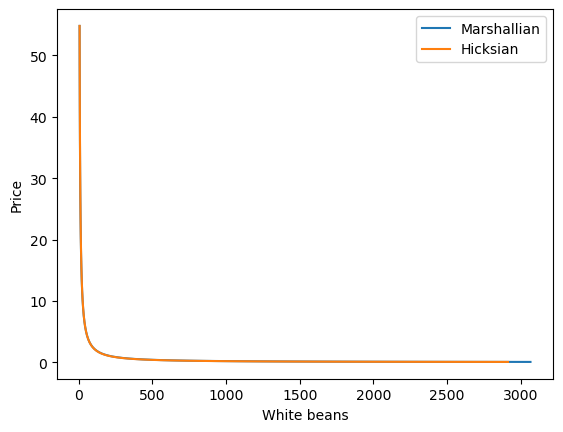

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([result.demands(x0,my_prices(p0,j=my_j))[my_j] for p0 in P],P)
plt.plot([result.demands(U0,my_prices(p0,j=my_j),type="Hicksian")[my_j] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_j)
plt.legend(("Marshallian","Hicksian"))

In [42]:
def compensating_variation(U0,p0,p1):
    x0 = result.expenditure(U0,p0)
    x1 = result.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = result.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian')

In the following graph, for the better understanding, we marked the price of the food in red line.

#### Compensating variation

(-0.1, 20.0)

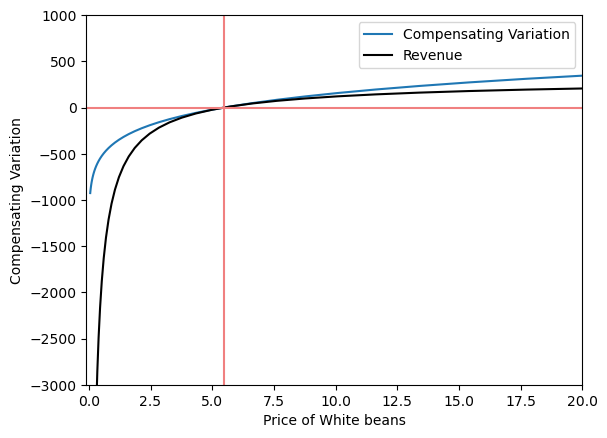

In [43]:
#Compensating variation for white beans
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(p0,j=my_j),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0, color = 'lightcoral')
ax1.axvline(pbar.loc[my_j], color = 'lightcoral')
ax1.set_ylim(bottom = -3000, top = 1000)
ax1.set_xlim(left = -0.1, right = 20)

(-0.1, 20.0)

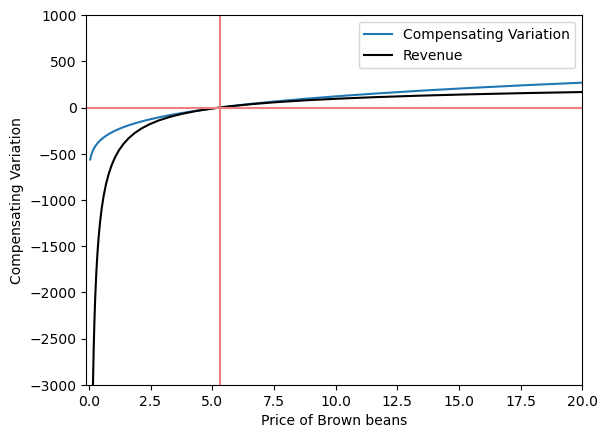

In [44]:
#Compensating variation for brown beans
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(p0,j=my_j1)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j1}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(p0,j=my_j1),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0, color = 'lightcoral')
ax1.axvline(pbar.loc[my_j1], color = 'lightcoral')
ax1.set_ylim(bottom = -3000, top = 1000)
ax1.set_xlim(left = -0.1, right = 20)

#### Deadweight Loss

(-0.1, 20.0)

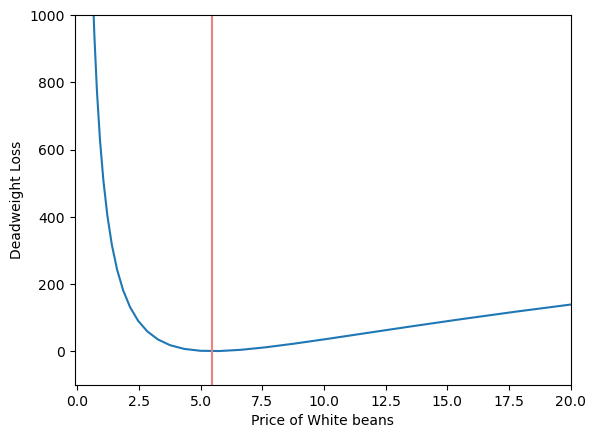

In [45]:
#Deadweight loss for white beans
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_j)
ax1.set_ylabel("Deadweight Loss")
ax1.axvline(pbar.loc[my_j], color = 'lightcoral')
ax1.set_ylim(bottom = -100, top = 1000)
ax1.set_xlim(left = -0.1, right = 20)

(-0.1, 20.0)

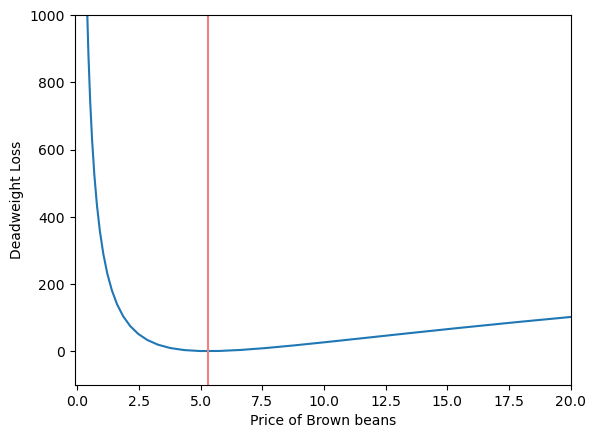

In [46]:
#Deadweight loss for brown beans
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,pbar,my_prices(p0,j=my_j1)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_j1)
ax1.set_ylabel("Deadweight Loss")
ax1.axvline(pbar.loc[my_j1], color = 'lightcoral')
ax1.set_ylim(bottom = -100, top = 1000)
ax1.set_xlim(left = -0.1, right = 20)

#### Nutrition and Demands

In [54]:
def nutrient_demand(x,p):
    c = result.demands(x,p)
    fct0,c0 = nutrition_chart.T.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

In [60]:
nutrition_chart.index.tolist()

['Alanine',
 'Alcohol, ethyl',
 'Amino acids',
 'Arginine',
 'Ash',
 'Aspartic acid',
 'Betaine',
 'Boron, B',
 'Caffeine',
 'Calcium, Ca',
 'Carbohydrate, by difference',
 'Carbohydrate, by summation',
 'Carbohydrates',
 'Carotene, alpha',
 'Carotene, beta',
 'Cholesterol',
 'Choline, total',
 'Cobalt, Co',
 'Copper, Cu',
 'Cryptoxanthin, beta',
 'Cysteine',
 'Cystine',
 'Energy',
 'Fatty acids, total monounsaturated',
 'Fatty acids, total polyunsaturated',
 'Fatty acids, total saturated',
 'Fatty acids, total trans',
 'Fatty acids, total trans-dienoic',
 'Fatty acids, total trans-monoenoic',
 'Fatty acids, total trans-polyenoic',
 'Fiber, total dietary',
 'Fluoride, F',
 'Folate, DFE',
 'Folate, food',
 'Folate, total',
 'Folic acid',
 'Fructose',
 'Galactose',
 'Glucose',
 'Glutamic acid',
 'Glycine',
 'Histidine',
 'Hydroxyproline',
 'Iron, Fe',
 'Isoleucine',
 'Lactose',
 'Leucine',
 'Lipids',
 'Lutein + zeaxanthin',
 'Lycopene',
 'Lysine',
 'MUFA 14:1',
 'MUFA 14:1 c',
 'MUFA 15:

In [78]:
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(uf

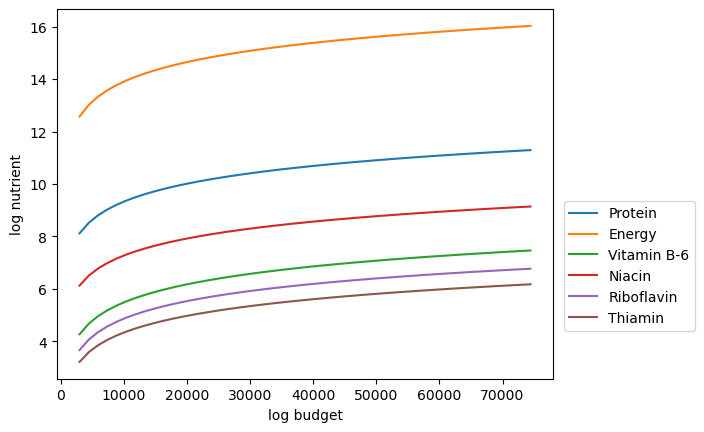

In [73]:
xref = xbar.quantile(0.5)  
X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Vitamin B-6','Niacin', 'Riboflavin', 'Thiamin']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')
ax.legend(bbox_to_anchor=(1.3, 0.5))

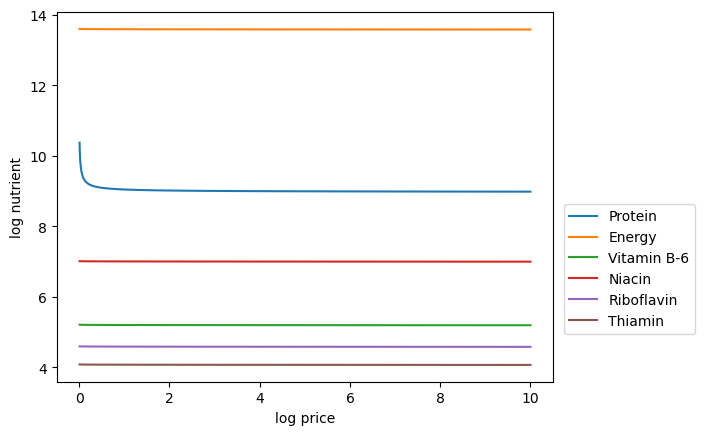

In [77]:
USE_GOOD = 'Brown beans'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')
ax.legend(bbox_to_anchor=(1.3, 0.5))